# Instruction for running
#### 1. Please keep all files in the same directory/same folder as of notebook. There is no need to create sub folder or change path.
#### 2. I have used two embeddings, one is Word2Vec, and another is GloVe. Word2Vec was used to augment the data, and I am providing the augmented data in a csv file, and also commented the augmenting code so that you don't have to run it again. I kept the code as a proof of how I augmented the data
#### 3. For GloVe I have used glove.6B.200d.txt . Please use the .txt format for that embedding, or else it won't run. Keep this embedding in the same folders of the notebook, again no need to create any folders


In [1]:
!pip install tensorflow
!pip install nlpaug
!pip install neattext
!pip install transformers
!pip install seaborn
!pip install pandas
!pip install scikit-learn
!pip install scipy==1.10.1
!pip install nltk
!pip install gensim
!pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pickle
import neattext.functions as nfx
from keras import Sequential
import tensorflow as tf
from tensorflow import keras
from keras.utils import pad_sequences, to_categorical
from keras.layers import Embedding, Dense, LSTM, Bidirectional, GlobalMaxPooling1D, Input, Dropout, Flatten
from keras import models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import SimpleRNN, GRU, RNN
from sklearn.metrics import classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification
import nlpaug.augmenter.word as naw
from nlpaug.util import Action
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [5]:
max_words = 100

In [6]:
dataset_path = '712_train_all_tasks.csv'

In [7]:
df1 = pd.read_csv(dataset_path)

In [8]:
df = df1

In [9]:
df.columns

Index(['rewire_id', 'text', 'label_sexist', 'label_category', 'label_vector'], dtype='object')

In [10]:
df['label_sexist'].value_counts()

label_sexist
not sexist    10602
sexist         3398
Name: count, dtype: int64

In [11]:
df['label_category'].value_counts()

label_category
none                                        10602
2. derogation                                1590
3. animosity                                 1165
4. prejudiced discussions                     333
1. threats, plans to harm and incitement      310
Name: count, dtype: int64

In [12]:
df.groupby(['label_category', 'label_sexist']).size().reset_index(name='Occurrence')

,label_category,label_sexist,Occurrence
0,"1. threats, plans to harm and incitement",sexist,310
1,2. derogation,sexist,1590
2,3. animosity,sexist,1165
3,4. prejudiced discussions,sexist,333
4,none,not sexist,10602


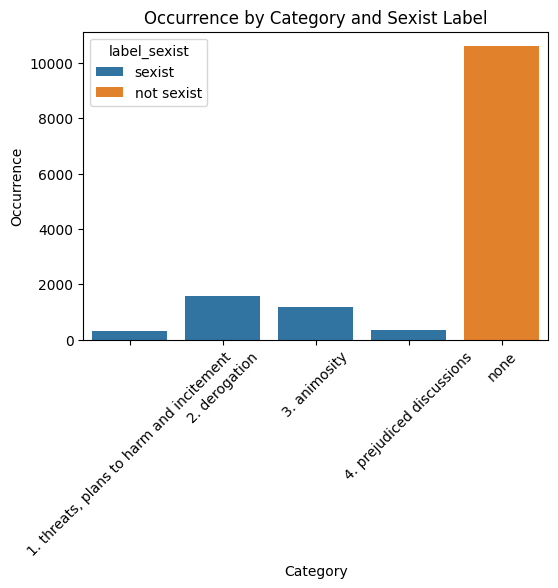

In [13]:
grouped_df = df.groupby(['label_category', 'label_sexist']).size().reset_index(name='Occurrence')

# Creating grouped bar plot
plt.figure(figsize=(6, 4))
plt.xticks(rotation=45)
sns.barplot(x='label_category', y='Occurrence', hue='label_sexist', data=grouped_df)
plt.title('Occurrence by Category and Sexist Label')
plt.xlabel('Category')
plt.ylabel('Occurrence')
plt.show()

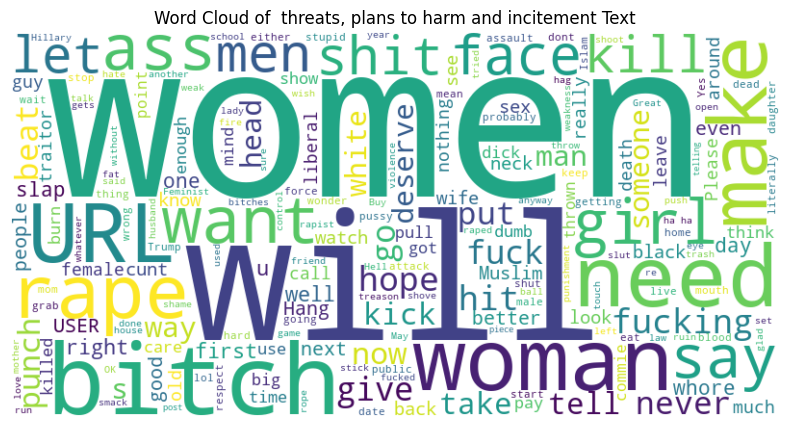

In [14]:
sexist_text = " ".join(df[df['label_category'] == '1. threats, plans to harm and incitement']['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sexist_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of  threats, plans to harm and incitement Text')
plt.axis('off')
plt.show()

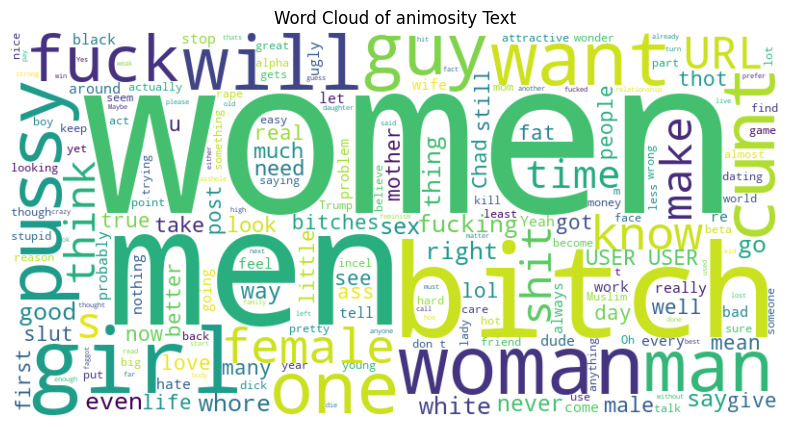

In [15]:
sexist_text = " ".join(df[df['label_category'] == '3. animosity']['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sexist_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of animosity Text')
plt.axis('off')
plt.show()

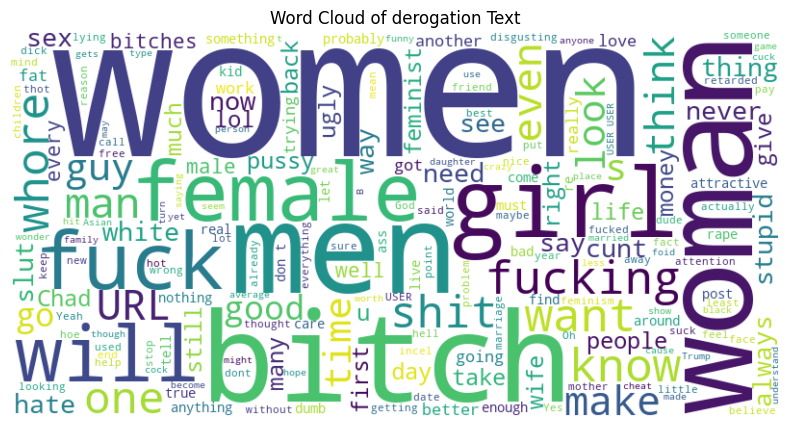

In [16]:
sexist_text = " ".join(df[df['label_category'] == '2. derogation']['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sexist_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of derogation Text')
plt.axis('off')
plt.show()

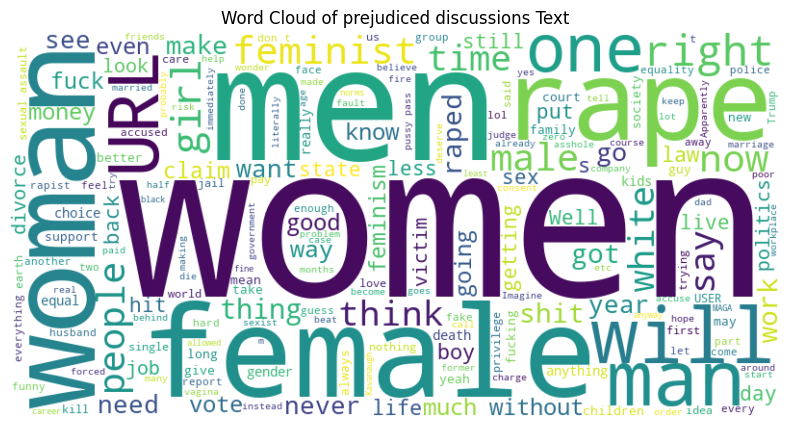

In [17]:
sexist_text = " ".join(df[df['label_category'] == '4. prejudiced discussions']['text'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(sexist_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of prejudiced discussions Text')
plt.axis('off')
plt.show()

In [18]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in text:
        sent = str(sent)
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

In [19]:
# embeddings = "50"
embeddings = "200"

In [20]:
df2 = pd.read_csv('glove.6B.'+ embeddings + 'd.txt', sep=" ", quoting=3, header=None, index_col=0)
glove = {key: val.values for key, val in df2.T.items()}

In [21]:
with open('glove.6B.' + embeddings+ 'd.pkl', 'wb') as fp:
    pickle.dump(glove, fp)
with open('glove.6B.' + embeddings+ 'd.pkl', 'rb') as fp:
    glove_embedding = pickle.load(fp)
pretrained_file_name = 'glove.6B.' + embeddings+ 'd.pkl'
with open(pretrained_file_name, 'rb') as fp:
    glove_embedding = pickle.load(fp)

In [22]:
df

,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none
...,...,...,...,...,...
13995,sexism2022_english-14185,complexes like the 'nice chicks' that go after...,sexist,2. derogation,2.1 descriptive attacks
13996,sexism2022_english-18629,"""GRAPHIC Germany - Muslim ""refugee"" stabbing h...",not sexist,none,none
13997,sexism2022_english-3320,Lol I imagine there would be simps that are li...,not sexist,none,none
13998,sexism2022_english-13309,"It's not, the girls I go on dates with don't k...",not sexist,none,none


In [23]:
df = df[df['label_sexist']=='sexist']
print(len(df))

3398


In [24]:
value_counts = df['label_category'].value_counts()
print(value_counts)

label_category
2. derogation                               1590
3. animosity                                1165
4. prejudiced discussions                    333
1. threats, plans to harm and incitement     310
Name: count, dtype: int64


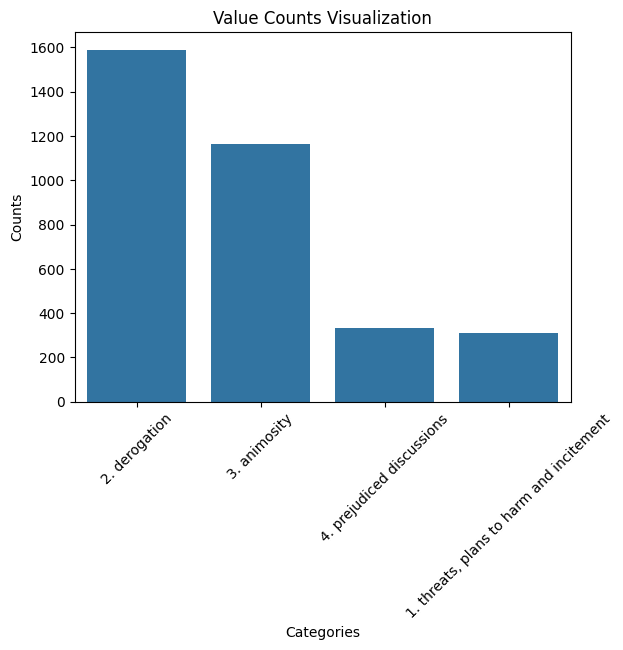

In [25]:
# Create a count plot
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Value Counts Visualization')
plt.show()

In [26]:
df.drop(['label_vector', 'rewire_id', 'label_sexist'], axis=1, inplace=True)
df.columns

C:\Users\User\AppData\Local\Temp\ipykernel_9872\366785279.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['label_vector', 'rewire_id', 'label_sexist'], axis=1, inplace=True)


Index(['text', 'label_category'], dtype='object')

# Data Augmentation
Augmenting dataset with help of word2vec, but no need to uncomment it as I have already saved the augmented data in a csv file (augmentation takes a long time to run). But I provided code so that if you want to check how I generated the data. 

In [23]:
# # Initialize the augmenter with model "fasttext"
# aug = naw.WordEmbsAug(
#   # You can choose from "word2vec", "glove", or "fasttext" 
#   model_type = 'word2vec', 
#   # Note: check your "content" path to find out specific model names
#   model_path = 'GoogleNews-vectors-negative300.bin',
#   # You may also choose "insert"
#   action = "substitute")

In [24]:
# augmented_data = []
# sexist_data = df[df['label_category'] == '1. threats, plans to harm and incitement']
# for j in range(4):
#     for i, text in enumerate(sexist_data['text']):
#         augmented_text = aug.augment(text)
#         # print(j, i, augmented_text)
#         augmented_data.append({'text': augmented_text, 'label_category': '1. threats, plans to harm and incitement'})
#     print('Round complete ', str(j))

In [25]:
# augmented_df = pd.DataFrame(augmented_data)
# augmented_df.to_csv('augmented_task_2_1.csv', index=False)

In [26]:
# augmented_data = []
# sexist_data = df[df['label_category'] == '4. prejudiced discussions']
# for j in range(4):
#     for i, text in enumerate(sexist_data['text']):
#         augmented_text = aug.augment(text)
#         # print(j, i, augmented_text)
#         augmented_data.append({'text': augmented_text, 'label_category': '4. prejudiced discussions'})
#     print('Round complete ', str(j))

In [27]:
# augmented_df_2 = pd.DataFrame(augmented_data)
# augmented_df_2.to_csv('augmented_task_2_2.csv', index=False)

In [28]:
# augmented_data = []
# sexist_data = df[df['label_category'] == '3. animosity']

# for i, text in enumerate(sexist_data['text'].head(425)):
#     augmented_text = aug.augment(text)
#     # print(i, augmented_text)
#     augmented_data.append({'text': augmented_text, 'label_category': '3. animosity'})

In [29]:
# augmented_df_3 = pd.DataFrame(augmented_data)
# augmented_df_3.to_csv('augmented_task_2_3.csv', index=False)

In [27]:
augmented_df = pd.read_csv('augmented_task_2_1.csv')
augmented_df_2 = pd.read_csv('augmented_task_2_2.csv')
augmented_df_3 = pd.read_csv('augmented_task_2_3.csv')

In [28]:
df = pd.concat([df, augmented_df, augmented_df_2, augmented_df_3], ignore_index=True)

In [29]:
df

,text,label_category
0,"just the inside of your wallet: cash, bank car...",2. derogation
1,They get the initial chance because they are a...,2. derogation
2,ugly chicks A pussy is a pussy.,2. derogation
3,fuck her off with a nine mm this is what you g...,"1. threats, plans to harm and incitement"
4,How about I talk shit to an idiot like you? Ar...,3. animosity
...,...,...
6390,['He should auction his virginity fοr st Billi...,3. animosity
6391,"['Well_whaddya tsk, Greek. Not ALL women. Some...",3. animosity
6392,"[""pizzagate isn ' didn_¿ really bitch""]",3. animosity
6393,['MGTOW is prelude tremolite_asbestos as Femin...,3. animosity


In [30]:
df['label_category'].value_counts()

label_category
4. prejudiced discussions                   1665
2. derogation                               1590
3. animosity                                1590
1. threats, plans to harm and incitement    1550
Name: count, dtype: int64

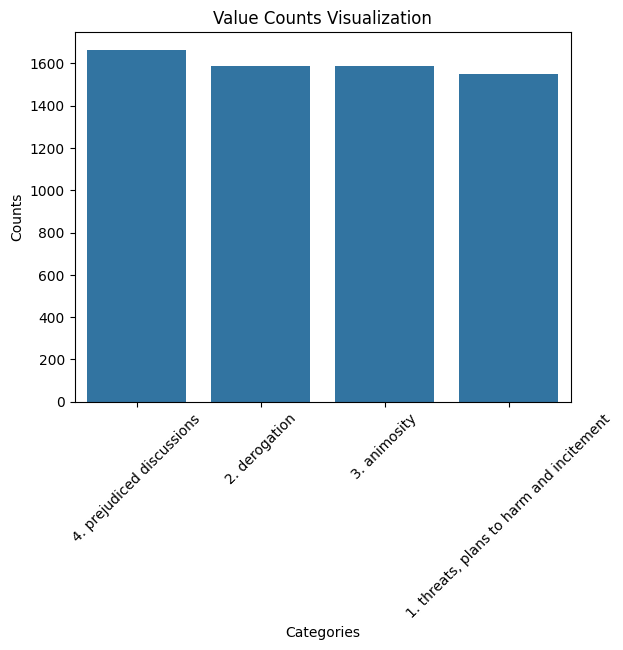

In [31]:

value_counts = df['label_category'].value_counts()

# Create a count plot
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.xlabel('Categories')
plt.xticks(rotation=45)
plt.ylabel('Counts')
plt.title('Value Counts Visualization')
plt.show()

In [32]:
def plot_training_curve(history, st):
    st = 'Training Curve for ' + st
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(st)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [33]:
def plot_training_curve_acc(history, st):
    st = 'Training Curve for ' + st
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title( st)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [34]:
txt, txt_length=clean_text(df['text'])

In [35]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(txt)

In [36]:
# Vocabulary size
vocab_size = len(tokenizer.word_index)
embedding_matrix=np.zeros((vocab_size+1,int(embeddings)), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [37]:
train_data, test_data = train_test_split(df, test_size=0.25, random_state=42)

In [38]:
mapping = { '1. threats, plans to harm and incitement'  : 3 , '2. derogation' : 2 , '3. animosity': 1, '4. prejudiced discussions': 0}
train_output = np.array([mapping[label] for label in train_data['label_category']])
test_output = np.array([mapping[label] for label in test_data['label_category']])

In [39]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

In [40]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=max_words)

test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=max_words)

# Neural Network Models

Set Number of epochs for all models here

In [43]:
epoch = 15

# Fully Connected Neural Network

In [45]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size + 1, int(embeddings), weights=[embedding_matrix], trainable=False ))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(train_text_pad, to_categorical(train_output, num_classes=4), epochs=epoch, validation_data=(test_text_pad, to_categorical(test_output, num_classes=4)))

Epoch 1/15
150/150 [==============================] - 5s 31ms/step - loss: 1.1808 - accuracy: 0.4662 - val_loss: 1.0314 - val_accuracy: 0.5341
Epoch 2/15
150/150 [==============================] - 4s 28ms/step - loss: 0.6656 - accuracy: 0.7269 - val_loss: 1.0519 - val_accuracy: 0.5428
Epoch 3/15
150/150 [==============================] - 4s 29ms/step - loss: 0.3227 - accuracy: 0.8776 - val_loss: 1.2496 - val_accuracy: 0.5485
Epoch 4/15
150/150 [==============================] - 4s 29ms/step - loss: 0.1707 - accuracy: 0.9364 - val_loss: 1.5378 - val_accuracy: 0.5635
Epoch 5/15
150/150 [==============================] - 4s 29ms/step - loss: 0.0751 - accuracy: 0.9735 - val_loss: 1.6208 - val_accuracy: 0.5985
Epoch 6/15
150/150 [==============================] - 4s 29ms/step - loss: 0.0866 - accuracy: 0.9708 - val_loss: 1.6872 - val_accuracy: 0.5929
Epoch 7/15
150/150 [==============================] - 4s 28ms/step - loss: 0.0803 - accuracy: 0.9716 - val_loss: 1.9833 - val_accuracy: 0.5629

In [47]:
loss, accuracy = model.evaluate(test_text_pad,   to_categorical(test_output), verbose=2)
print(accuracy)
print(loss)

50/50 - 0s - loss: 2.3799 - accuracy: 0.5541 - 331ms/epoch - 7ms/step
0.5540962815284729
2.3798954486846924


In [48]:
predictions = model.predict(test_text_pad)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(to_categorical(test_output), axis=1)

report = classification_report(true_labels, predicted_labels)
print(report)

50/50 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       422
           1       0.41      0.32      0.36       388
           2       0.45      0.56      0.49       416
           3       0.68      0.64      0.66       373

    accuracy                           0.55      1599
   macro avg       0.56      0.55      0.55      1599
weighted avg       0.56      0.55      0.55      1599



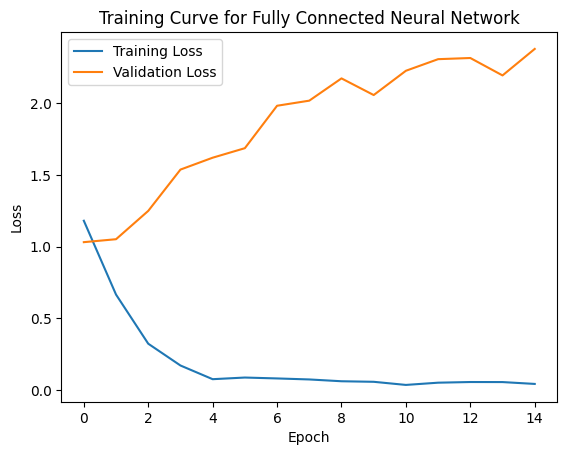

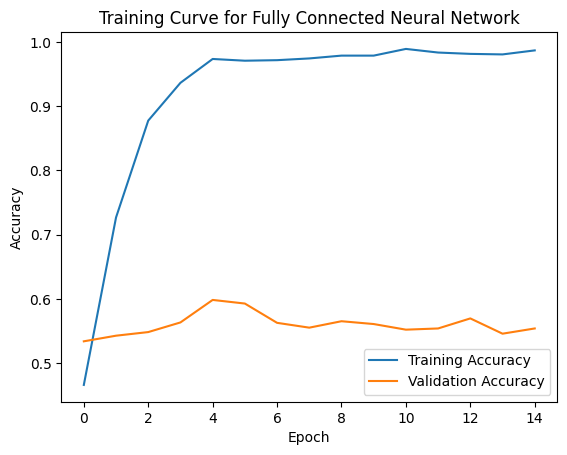

In [49]:
plot_training_curve(history, 'Fully Connected Neural Network')
plot_training_curve_acc(history, 'Fully Connected Neural Network')

In [50]:
m1 = model

# Bidrectional LSTM

In [51]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size+1,int(embeddings),weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [52]:
history = model.fit(train_text_pad, to_categorical(train_output, num_classes=4), epochs=epoch, validation_data=(test_text_pad, to_categorical(test_output, num_classes=4)))

Epoch 1/15
150/150 [==============================] - 94s 551ms/step - loss: 1.1596 - accuracy: 0.4727 - val_loss: 1.0198 - val_accuracy: 0.5522
Epoch 2/15
150/150 [==============================] - 71s 476ms/step - loss: 0.8905 - accuracy: 0.6157 - val_loss: 0.8427 - val_accuracy: 0.6391
Epoch 3/15
150/150 [==============================] - 25s 167ms/step - loss: 0.7307 - accuracy: 0.6895 - val_loss: 0.8393 - val_accuracy: 0.6429
Epoch 4/15
150/150 [==============================] - 33s 217ms/step - loss: 0.5828 - accuracy: 0.7573 - val_loss: 0.7279 - val_accuracy: 0.6867
Epoch 5/15
150/150 [==============================] - 32s 214ms/step - loss: 0.4457 - accuracy: 0.8094 - val_loss: 0.7489 - val_accuracy: 0.6942
Epoch 6/15
150/150 [==============================] - 31s 209ms/step - loss: 0.3792 - accuracy: 0.8428 - val_loss: 0.7334 - val_accuracy: 0.7167
Epoch 7/15
150/150 [==============================] - 23s 157ms/step - loss: 0.3079 - accuracy: 0.8741 - val_loss: 0.8058 - val_ac

In [53]:
loss, accuracy = model.evaluate(test_text_pad,   to_categorical(test_output), verbose=2)
print(accuracy)
print(loss)

50/50 - 3s - loss: 1.0154 - accuracy: 0.7273 - 3s/epoch - 58ms/step
0.7273295521736145
1.015425205230713


In [54]:
predictions = model.predict(test_text_pad)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(to_categorical(test_output), axis=1)

report = classification_report(true_labels, predicted_labels)
print(report)

50/50 [==============================] - 4s 64ms/step
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       422
           1       0.61      0.52      0.56       388
           2       0.65      0.62      0.63       416
           3       0.84      0.87      0.85       373

    accuracy                           0.73      1599
   macro avg       0.72      0.73      0.72      1599
weighted avg       0.72      0.73      0.72      1599



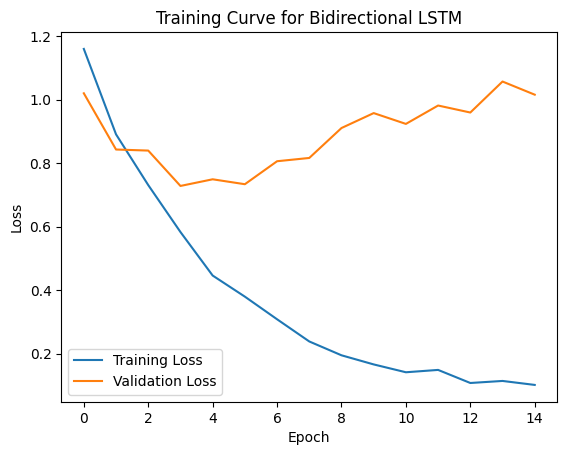

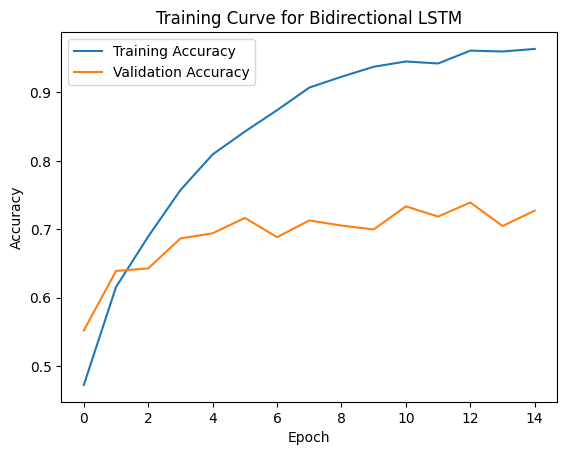

In [55]:
plot_training_curve(history, 'Bidirectional LSTM')
plot_training_curve_acc(history, 'Bidirectional LSTM')

In [56]:
m2 = model

# Bidrectional RNN

In [57]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size+1,int(embeddings),weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(SimpleRNN(128,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
history = model.fit(train_text_pad, to_categorical(train_output, num_classes=4), epochs=epoch, validation_data=(test_text_pad, to_categorical(test_output, num_classes=4)))

Epoch 1/15
150/150 [==============================] - 23s 140ms/step - loss: 1.3038 - accuracy: 0.3941 - val_loss: 1.0954 - val_accuracy: 0.5153
Epoch 2/15
150/150 [==============================] - 20s 133ms/step - loss: 1.0493 - accuracy: 0.5236 - val_loss: 1.0150 - val_accuracy: 0.5278
Epoch 3/15
150/150 [==============================] - 20s 134ms/step - loss: 0.9296 - accuracy: 0.5878 - val_loss: 0.9433 - val_accuracy: 0.5797
Epoch 4/15
150/150 [==============================] - 20s 133ms/step - loss: 0.9136 - accuracy: 0.6022 - val_loss: 0.9001 - val_accuracy: 0.6104
Epoch 5/15
150/150 [==============================] - 15s 99ms/step - loss: 0.7433 - accuracy: 0.6837 - val_loss: 0.8965 - val_accuracy: 0.6079
Epoch 6/15
150/150 [==============================] - 19s 125ms/step - loss: 0.6330 - accuracy: 0.7327 - val_loss: 0.8673 - val_accuracy: 0.6304
Epoch 7/15
150/150 [==============================] - 20s 134ms/step - loss: 0.5327 - accuracy: 0.7775 - val_loss: 0.8784 - val_acc

In [59]:
loss, accuracy = model.evaluate(test_text_pad,   to_categorical(test_output), verbose=2)
print(accuracy)
print(loss)

50/50 - 1s - loss: 1.0402 - accuracy: 0.6779 - 1s/epoch - 29ms/step
0.6779236793518066
1.040234088897705


In [60]:
predictions = model.predict(test_text_pad)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(to_categorical(test_output), axis=1)

report = classification_report(true_labels, predicted_labels)
print(report)

50/50 [==============================] - 2s 30ms/step
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       422
           1       0.58      0.39      0.47       388
           2       0.59      0.66      0.62       416
           3       0.71      0.88      0.78       373

    accuracy                           0.68      1599
   macro avg       0.67      0.68      0.67      1599
weighted avg       0.67      0.68      0.67      1599



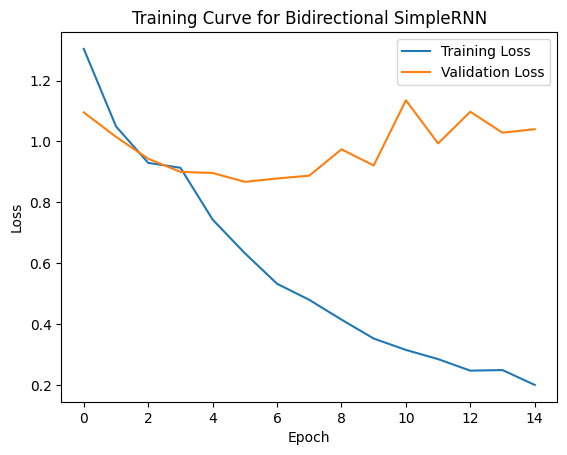

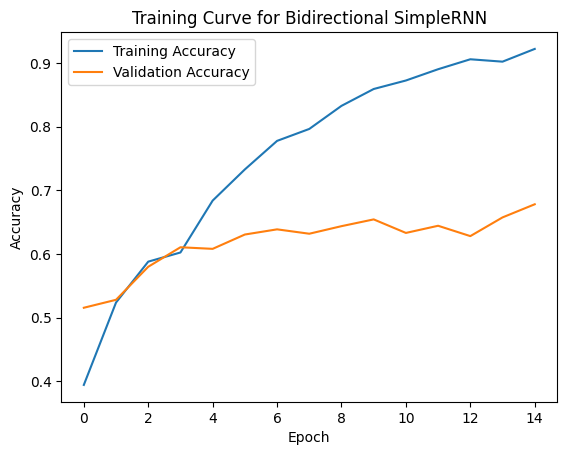

In [61]:
plot_training_curve(history, 'Bidirectional SimpleRNN')
plot_training_curve_acc(history, 'Bidirectional SimpleRNN' )

In [62]:
m3 = model

# Bidirectional GRU

In [44]:
model=Sequential()
model.add(Input(shape=(max_words,)))
model.add(Embedding(vocab_size+1,int(embeddings),weights=[embedding_matrix],trainable=False))
model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.3))
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4,activation='softmax'))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
history = model.fit(train_text_pad, to_categorical(train_output, num_classes=4), epochs=epoch, validation_data=(test_text_pad, to_categorical(test_output, num_classes=4)))

Epoch 1/15
150/150 [==============================] - 16s 85ms/step - loss: 1.1686 - accuracy: 0.4656 - val_loss: 1.0112 - val_accuracy: 0.5466
Epoch 2/15
150/150 [==============================] - 12s 83ms/step - loss: 0.8924 - accuracy: 0.6163 - val_loss: 0.8462 - val_accuracy: 0.6423
Epoch 3/15
150/150 [==============================] - 12s 83ms/step - loss: 0.6838 - accuracy: 0.7010 - val_loss: 0.8091 - val_accuracy: 0.6517
Epoch 4/15
150/150 [==============================] - 12s 80ms/step - loss: 0.5445 - accuracy: 0.7759 - val_loss: 0.7919 - val_accuracy: 0.6648
Epoch 5/15
150/150 [==============================] - 12s 82ms/step - loss: 0.4475 - accuracy: 0.8094 - val_loss: 0.7730 - val_accuracy: 0.6942
Epoch 6/15
150/150 [==============================] - 12s 83ms/step - loss: 0.3682 - accuracy: 0.8520 - val_loss: 0.7549 - val_accuracy: 0.6973
Epoch 7/15
150/150 [==============================] - 13s 84ms/step - loss: 0.3073 - accuracy: 0.8757 - val_loss: 0.7082 - val_accuracy:

In [46]:
loss, accuracy = model.evaluate(test_text_pad,   to_categorical(test_output), verbose=2)
print(accuracy)
print(loss)

50/50 - 1s - loss: 1.0548 - accuracy: 0.7129 - 1s/epoch - 23ms/step
0.7129455804824829
1.0548481941223145


In [47]:
predictions = model.predict(test_text_pad)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(to_categorical(test_output), axis=1)

report = classification_report(true_labels, predicted_labels)
print(report)

50/50 [==============================] - 2s 24ms/step
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       422
           1       0.58      0.58      0.58       388
           2       0.64      0.57      0.60       416
           3       0.87      0.79      0.83       373

    accuracy                           0.71      1599
   macro avg       0.71      0.71      0.71      1599
weighted avg       0.71      0.71      0.71      1599



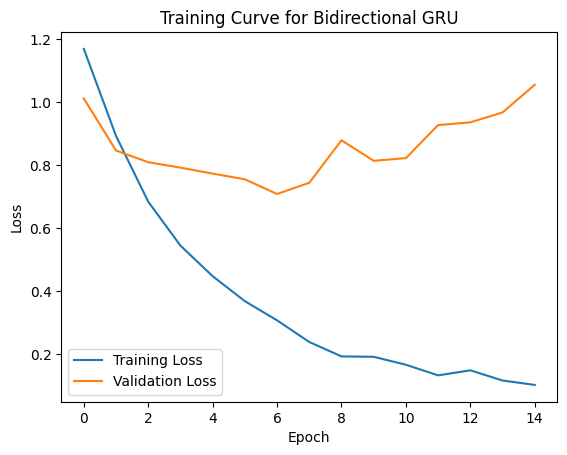

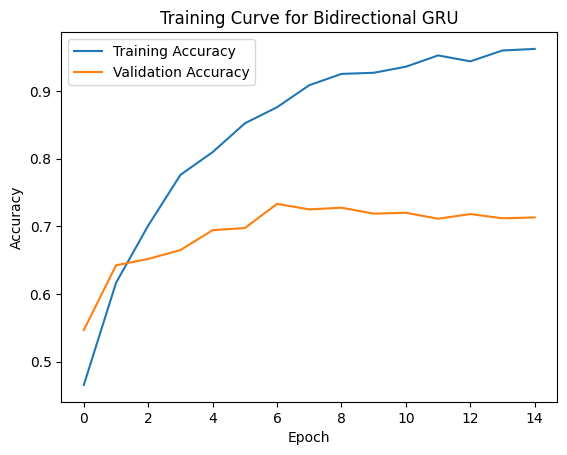

In [48]:
plot_training_curve(history, 'Bidirectional GRU')
plot_training_curve_acc(history, 'Bidirectional GRU' )

In [ ]:
m4 = model

# BERT

In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)  # Adjust num_labels based on your task

# Compile the model with appropriate loss function
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Fine-tune the BERT model
model.fit(train_text_pad, to_categorical(train_output, num_classes=4), batch_size=32, epochs=5, validation_data=(test_text_pad, to_categorical(test_output, num_classes=4)))

150/150 [==============================] - 1316s 9s/step - loss: 1.4451 - accuracy: 0.2550 - val_loss: 1.4140 - val_accuracy: 0.2639
Epoch 2/5
150/150 [==============================] - 1246s 8s/step - loss: 1.4603 - accuracy: 0.2519 - val_loss: 1.4212 - val_accuracy: 0.2427
Epoch 3/5
150/150 [==============================] - 1185s 8s/step - loss: 1.4330 - accuracy: 0.2658 - val_loss: 1.3927 - val_accuracy: 0.2427
Epoch 4/5
150/150 [==============================] - 1142s 8s/step - loss: 1.4238 - accuracy: 0.2606 - val_loss: 1.5134 - val_accuracy: 0.2333
Epoch 5/5
150/150 [==============================] - 1141s 8s/step - loss: 1.4421 - accuracy: 0.2519 - val_loss: 1.4202 - val_accuracy: 0.2333


In [70]:
loss, accuracy = model.evaluate(test_text_pad,   to_categorical(test_output), verbose=2)
print(accuracy)
print(loss)

50/50 - 111s - loss: 1.4202 - accuracy: 0.2333 - 111s/epoch - 2s/step
0.2332707941532135
1.4202169179916382


In [71]:
predictions = model.predict(test_text_pad)

50/50 [==============================] - 117s 2s/step


In [ ]:
predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(to_categorical(test_output), axis=1)

report = classification_report(true_labels, predicted_labels)
print(report)